In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.set_printoptions(threshold=np.inf)

path = 'return-data/'
filelist = os.listdir(path) 
dfs = [pd.read_json(path+file, lines=True) for file in filelist]
toydata = pd.concat(dfs, ignore_index=True)

In [2]:
toydata.head()

,basket,returnLabel,totalAmount,transactionId,zipCode
0,"[1, 1, 0, 2, 5, 1, 2, 2]",0,264,5221131913,2321
1,"[1, 4, 4, 3, 2, 4]",1,60,4768566069,7597
2,[5],0,60,4791292369,1176
3,"[0, 4, 3]",0,333,4672834572,3087
4,"[2, 3, 1, 2, 0, 0]",0,378,8750635039,9400


In [3]:
toydata = toydata.merge(toydata['basket'].apply(lambda x: pd.Series({'c_0': x.count(0), 'c_1': x.count(1),'c_2': x.count(2),'c_3': x.count(3),'c_4': x.count(4),'c_5': x.count(5)})), left_index=True, right_index=True)

In [4]:
toydata.drop(['basket','transactionId','zipCode'],axis=1,inplace=True)
toydata.head()

,returnLabel,totalAmount,c_0,c_1,c_2,c_3,c_4,c_5
0,0,264,1,3,3,0,0,1
1,1,60,0,1,1,1,3,0
2,0,60,0,0,0,0,0,1
3,0,333,1,0,0,1,1,0
4,0,378,2,1,2,1,0,0


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(toydata.drop('returnLabel',axis=1),toydata['returnLabel'], test_size=0.30,random_state=101)

In [6]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(solver='lbfgs')
log_clf.fit(X_train,y_train)
log_predictions = log_clf.predict(X_test)

c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(y_test,log_predictions))
print("Accuracy:",accuracy_score(y_test, log_predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9001
           1       0.77      0.24      0.37       299

   micro avg       0.97      0.97      0.97      9300
   macro avg       0.87      0.62      0.68      9300
weighted avg       0.97      0.97      0.97      9300

('Accuracy:', 0.9733333333333334)


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

random_clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
random_clf.fit(X_train,y_train)
random_predictions = random_clf.predict(X_test)

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(y_test,random_predictions))
print("Accuracy:",accuracy_score(y_test, random_predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9001
           1       0.00      0.00      0.00       299

   micro avg       0.97      0.97      0.97      9300
   macro avg       0.48      0.50      0.49      9300
weighted avg       0.94      0.97      0.95      9300

('Accuracy:', 0.9678494623655914)


c:\python27\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
def roc_curve_scratch(true_labels, predictions):

    prediction_desc = -np.sort(-predictions)

    fprs = np.array([])
    tprs = np.array([])
    
    for i in range(prediction_desc.size):
        threshold = (prediction_desc[i])
        tmp = np.copy(prediction_desc)
        tmp[tmp >= threshold], tmp[tmp < threshold] = 1,0
        
        tp = np.sum(np.logical_and(tmp == 1, true_labels == 1))
        tn = np.sum(np.logical_and(tmp == 0, true_labels == 0))
        fp = np.sum(np.logical_and(tmp == 1, true_labels == 0))
        fn = np.sum(np.logical_and(tmp == 0, true_labels == 1))
        
        fpr = (fp*1.0)/(tn+fp)
        tpr = (tp*1.0)/(tp+fn)

        fprs = np.append(fprs, fpr)
        tprs = np.append(tprs, tpr)

    return fprs, tprs

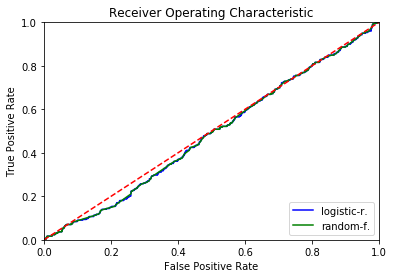

In [12]:
# logistic regression roc
y_pred_proba_log = log_clf.predict_proba(X_test)[::,1]
fpr_log, tpr_log = roc_curve_scratch(y_test, y_pred_proba_log)

# random forest roc
y_pred_proba_rnd = random_clf.predict_proba(X_test)[::,1]
fpr_rnd, tpr_rnd = roc_curve_scratch(y_test, y_pred_proba_rnd)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_log, tpr_log, 'b', label = 'logistic-r.')
plt.plot(fpr_rnd, tpr_rnd, 'g', label = 'random-f.')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()